# Load Dataset for Internet Traffic Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data=pd.read_csv('/content/drive/MyDrive/webtraffic.csv')

# Check the shape of the data

In [4]:
data.shape

(4896, 2)

In [5]:
data.head()


,Hour Index,Sessions
0,0,1418159421
1,1,1113769116
2,2,919158921
3,3,822352824
4,4,735526737


In [6]:
sessions = data['Sessions'].values

# *Visualize the whole dataset*

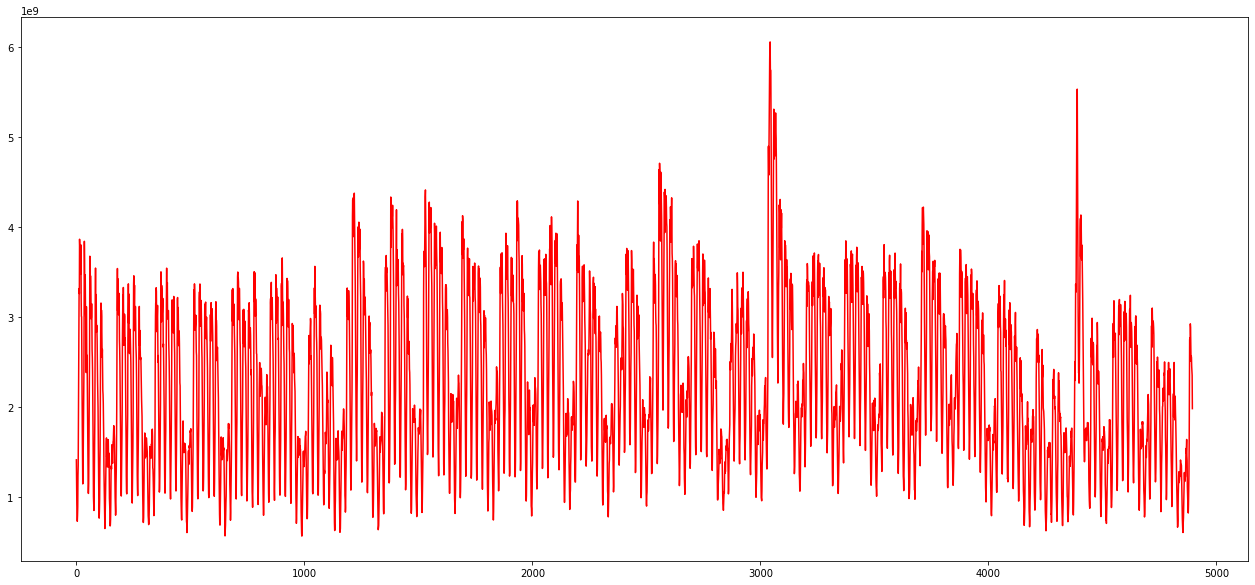

In [7]:
ar = np.arange(len(sessions))
plt.figure(figsize = (22,10))
plt.plot(ar, sessions, 'r')
plt.show()

*First week web trafic*

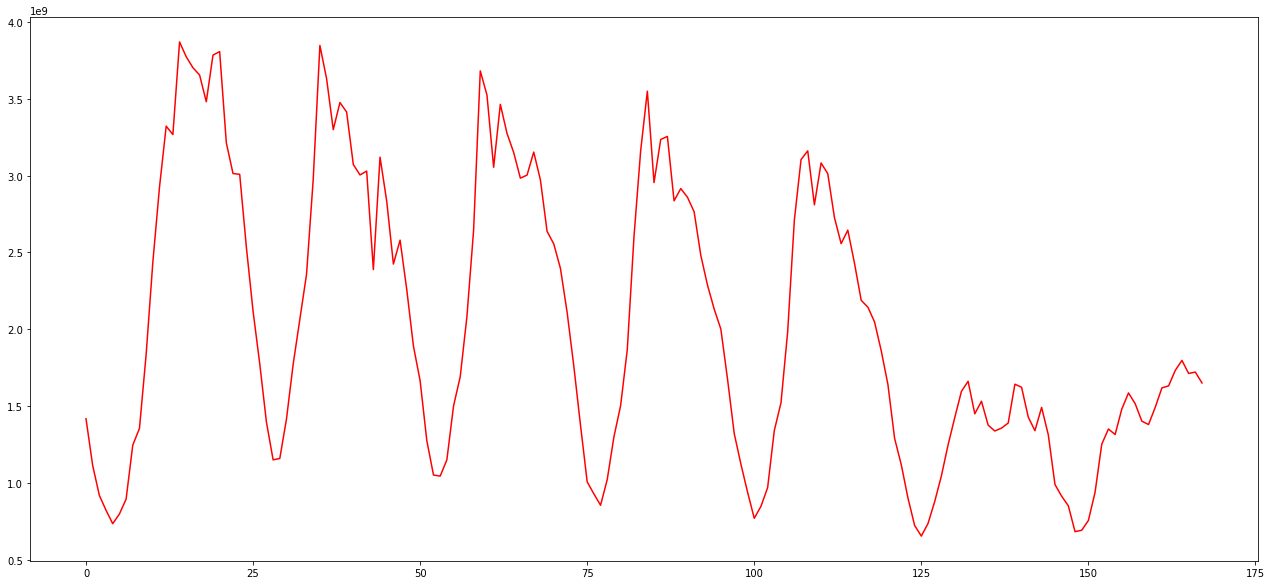

In [8]:
sample = sessions[:168]
ar = np.arange(len(sample))
plt.figure(figsize = (22,10))
plt.plot(ar, sample, 'r')
plt.show()

# Data Preparation for Web Traffic Forecasting

In [9]:
def prepare_data(seq,num):
  x=[]
  y=[]

  for i in range(0,(len(seq)-num),1):
    
    input_ = seq[i:i+num]
    output  = seq[i+num]
    
    x.append(input_)
    y.append(output)
    
  return np.array(x), np.array(y)

In [10]:
num=168
x,y= prepare_data(sessions,num)
print(len(x))

4728


# *Split the Dataset*

In [11]:
ind = int(0.9*len(x))

# prepare training and test data
X_train = x[:ind]
y_train = y[:ind]

X_test = x[ind:]
y_test = y[ind:]

# ***Scaling***

In [12]:
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.fit_transform(X_test)

In [13]:
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

In [14]:
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)[:, 0]
y_test = y_scaler.fit_transform(y_test)[:, 0]

***After that, we are reshaping the data from two dimensional to 3 dimensional***

In [15]:
X_train= X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test= X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print(X_train.shape)

(4255, 168, 1)


# *Model Building for Web Traffic Forecasting*

In [16]:
model = Sequential()
model.add(LSTM(128, input_shape = (168,1)))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

*Have a look at the activation at the final layer above the code It is linear. This is because we have to predict a continuous value and not some class tag or category as it is a regression problem and not a classification problem. Other than that we are using a single layer of LSTM here and the input shape is 168 that is one week*

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,881
Trainable params: 74,881
Non-trainable params: 0
_________________________________________________________________


*Define the optimizer and loss*

*Train the model for 30 epochs with batch size of 32*

In [18]:
model.compile(loss = 'mse', optimizer = 'adam')
mc = ModelCheckpoint('best_model.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = True, mode = min)
# train the model

history = model.fit(X_train, y_train, epochs = 100, batch_size = 32,validation_data = (X_test, y_test), callbacks = [mc])

Epoch 1/100
130/133 [============================>.] - ETA: 0s - loss: 0.1990
Epoch 1: val_loss improved from inf to 0.06216, saving model to best_model.hdf5
133/133 [==============================] - 9s 17ms/step - loss: 0.1955 - val_loss: 0.0622
Epoch 2/100
129/133 [============================>.] - ETA: 0s - loss: 0.0417
Epoch 2: val_loss improved from 0.06216 to 0.04247, saving model to best_model.hdf5
133/133 [==============================] - 1s 11ms/step - loss: 0.0418 - val_loss: 0.0425
Epoch 3/100
132/133 [============================>.] - ETA: 0s - loss: 0.0350
Epoch 3: val_loss did not improve from 0.04247
133/133 [==============================] - 1s 11ms/step - loss: 0.0351 - val_loss: 0.0426
Epoch 4/100
133/133 [==============================] - ETA: 0s - loss: 0.0339
Epoch 4: val_loss improved from 0.04247 to 0.03981, saving model to best_model.hdf5
133/133 [==============================] - 1s 11ms/step - loss: 0.0339 - val_loss: 0.0398
Epoch 5/100
131/133 [============

*Define the callback to save the best model during the training*

***Load the weights of best model prior to predictions***

In [19]:
model.load_weights('best_model.hdf5')

*Evaluate the performance of model on the validation data*

In [20]:
mse = model.evaluate(X_train, y_train)
print("Mean Square Error:",mse)

133/133 [==============================] - 1s 5ms/step - loss: 0.0123
Mean Square Error: 0.01230232510715723


In [21]:
model.compile(loss='mse',optimizer='adam')

In [22]:
model.load_weights('best_model.hdf5')

# ***Internet Traffic Forecasting***

#Now moving on to forecasting. These are the steps that we will follow:-

1.first, initialize an array with weeks data,

2. Predict the next hour traffic volume

3. Append the predicted value at the end of the array ‘data

4. Skip the first element of the array ‘data’

5. Repeating steps, from the second step till the fourth step for the specified number of iterations.

In [23]:
def Forecast(X_test, no_of_pred, ind):
    predictions = []
    temp = X_test[ind]
    for i in range(no_of_pred):
        pred = model.predict(temp.reshape(1,-1,1))[0][0]
        temp = np.insert(temp, len(temp), pred)
        predictions.append(pred)
        temp = temp[1:]
    return predictions

*It’s time to forecast the traffic for the next 24 hours based on the previous week data*

In [24]:
no_of_pred = 24
ind = 72
y_pred = Forecast(X_test, no_of_pred, ind)
y_true = y_test[ind:ind+(no_of_pred)]

1/1 [==============================] - 0s 19ms/step


*Define a function which forecasts the traffic for the next hours from the previous week data*

In [25]:
def forecast(x_val, no_of_pred, ind):
  predictions=[]

  #intialize the array with a weeks data
  temp=x_val[ind]

  for i in range(no_of_pred): 

    #predict for the next hour
    pred=model.predict(temp.reshape(1,-1,1))[0][0]
    
    #append the prediction as the last element of array
    temp = np.insert(temp,len(temp),pred)
    predictions.append(pred)

    #ignore the first element of array
    temp = temp[1:]

  return predictions

*Now let’s look at the plot of real vs forecast values*

In [26]:
def plot(y_true,y_pred):
  ar = np.arange(len(y_true))
  plt.figure(figsize=(22,10))
  plt.plot(ar, y_true,'r')
  plt.plot(ar, y_pred,'y')
  plt.show()

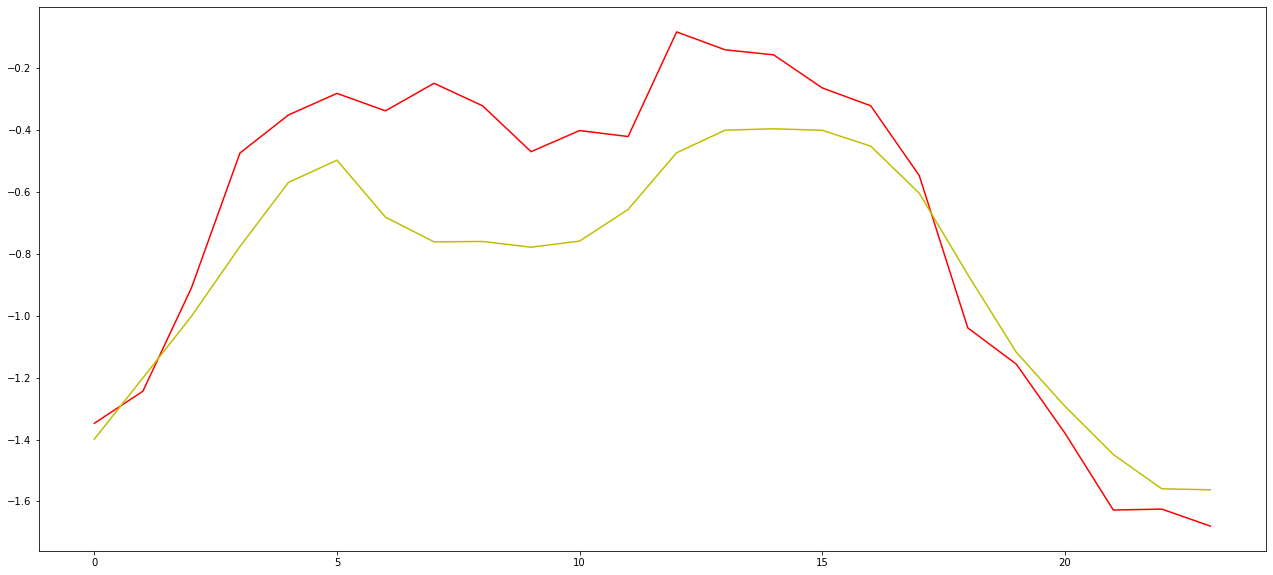

In [27]:
plot(y_true, y_pred)

# ***The Red curve is the actual value and the yellow curve is our predicted value and both are pretty much close to each other***